# 04 Exercise Binary Dogs Cats

PyTorch: 2.10.0+cu128
Torchvision: 0.25.0+cu128
Device: cuda
GPU disponibile: True


100%|██████████| 170M/170M [00:05<00:00, 32.0MB/s]


Training set: (50000, 32, 32, 3)
Test set: (10000, 32, 32, 3)
Range valori: [0, 255]
Classi: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


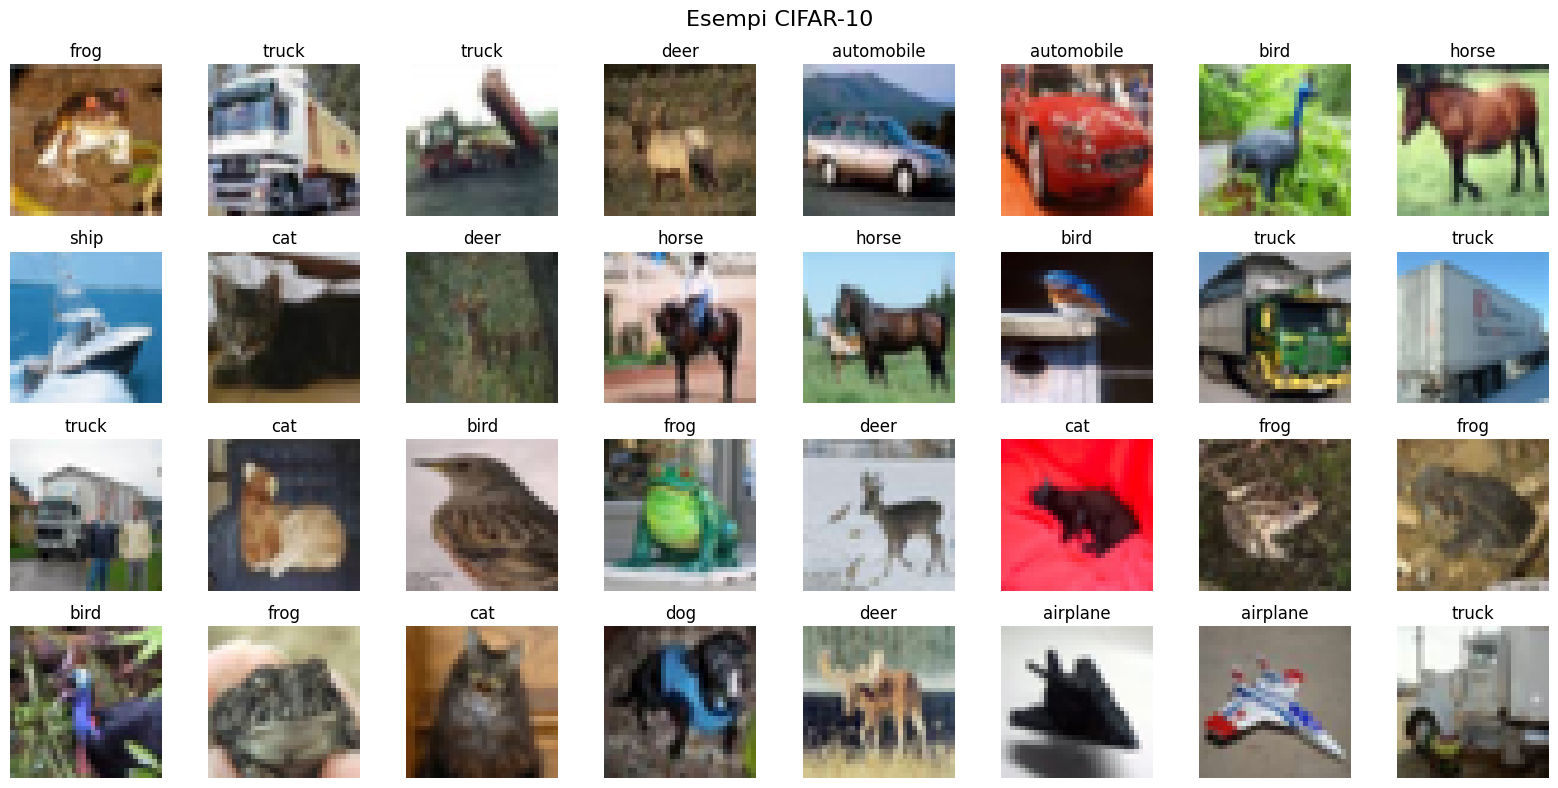

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"Device: {device}")
print(f"GPU disponibile: {torch.cuda.is_available()}")

# Caricamento CIFAR-10
transform_basic = transforms.ToTensor()

trainset_full = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True,
    transform=transform_basic
)
testset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True,
    transform=transform_basic
)

# Per avere anche array numpy (utile per visualizzazioni)
trainset_raw = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True,
    transform=None
)
testset_raw = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True,
    transform=None
)

# Nomi classi CIFAR-10
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Estrai dati come numpy per preprocessing/visualizzazione
X_train = np.array([np.array(img) for img, _ in trainset_raw])
y_train = np.array([label for _, label in trainset_raw])
X_test = np.array([np.array(img) for img, _ in testset_raw])
y_test = np.array([label for _, label in testset_raw])

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Range valori: [{X_train.min()}, {X_train.max()}]")
print(f"Classi: {class_names}")

# Visualizzazione esempi
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.set_title(class_names[y_train[i]])
    ax.axis('off')
plt.suptitle('Esempi CIFAR-10', fontsize=16)
plt.tight_layout()
plt.show()

import os, urllib.request

# GitHub Release URL for pretrained weights (update with actual URL)
WEIGHTS_BASE_URL = os.environ.get('WEIGHTS_URL', 'https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/')
WEIGHTS_DIR = '../pretrained_weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

def load_or_train(model, train_fn, weights_filename, device='cpu'):
    """Load pretrained weights if available, otherwise train and save.
    Also saves/loads training history as JSON alongside weights."""
    weights_path = os.path.join(WEIGHTS_DIR, weights_filename)
    history_path = weights_path.replace('.pt', '_history.json')

    def _load_history():
        if os.path.exists(history_path):
            import json as _json
            with open(history_path, 'r') as f:
                return _json.load(f)
        return None

    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
        print(f"Loaded pretrained weights from {weights_path}")
        return _load_history()
    elif WEIGHTS_BASE_URL:
        try:
            url = WEIGHTS_BASE_URL + weights_filename
            urllib.request.urlretrieve(url, weights_path)
            try:
                urllib.request.urlretrieve(
                    WEIGHTS_BASE_URL + weights_filename.replace('.pt', '_history.json'), history_path)
            except Exception:
                pass
            model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
            print(f"Downloaded and loaded weights from {url}")
            return _load_history()
        except Exception as e:
            print(f"Could not download weights: {e}. Training from scratch...")

    history = train_fn()
    torch.save(model.state_dict(), weights_path)
    print(f"Saved weights to {weights_path}")
    if history is not None:
        import json as _json
        with open(history_path, 'w') as f:
            _json.dump(history, f)
        print(f"Saved training history to {history_path}")
    return history

## Esercizio 2

Dataset Cani vs Gatti
Train: (2800, 64, 64, 3), Val: (600, 64, 64, 3), Test: (600, 64, 64, 3)
Distribuzione train: Cani=1403, Gatti=1397


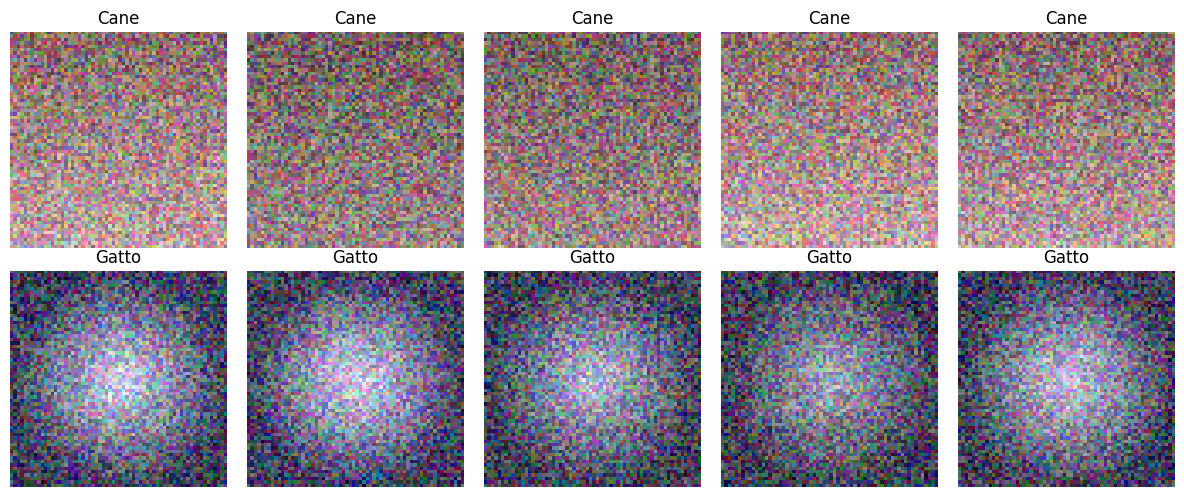


Architettura CNN:
BinaryCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=128, bias=True)
    (2): ReL

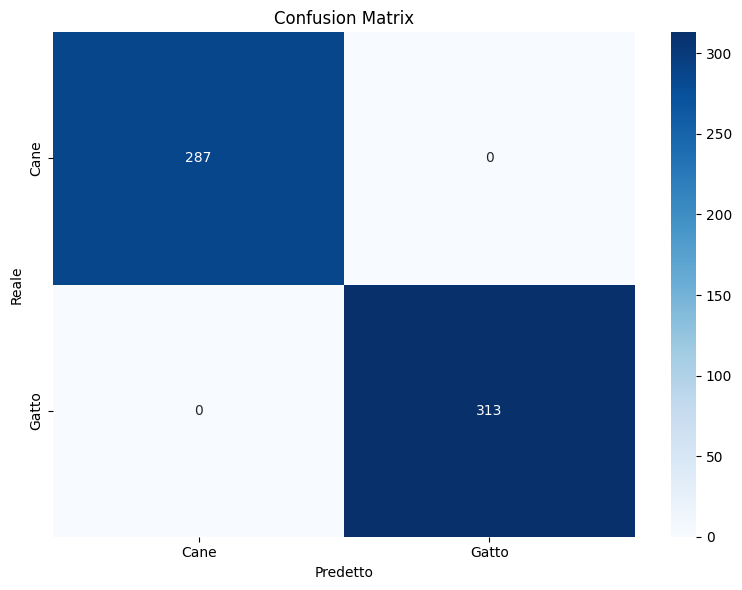


Classification Report:
              precision    recall  f1-score   support

        Cane       1.00      1.00      1.00       287
       Gatto       1.00      1.00      1.00       313

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600


Esercizio 2 completato!


In [7]:
# ==========================================================
# ESERCIZIO 2: Costruzione e Training CNN da Zero
# ==========================================================
# Task: Costruire una CNN per classificazione binaria
#       di cani vs gatti
# Dataset: Subset di 4000 immagini 64x64 sintetiche
#          (2000 cani, 2000 gatti)
#
# NOTA: usiamo variabili con suffisso _ex2 per non
#       sovrascrivere i dati CIFAR-10 principali.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Generazione dataset sintetico cani vs gatti
np.random.seed(456)

def generate_synthetic_images(
    n_samples, img_size=64, category=0
):
    images = np.random.rand(
        n_samples, img_size, img_size, 3
    ).astype('float32')

    for i in range(n_samples):
        noise = np.random.uniform(0.8, 1.2)
        if category == 0:  # Cani
            gradient = np.linspace(0.3, 0.7, img_size)
            gradient = gradient.reshape(-1, 1, 1)
            images[i] = images[i] * 0.5 + gradient * noise * 0.5
            images[i, :, :, 0] += 0.1 * noise
        else:  # Gatti
            cx, cy = img_size // 2, img_size // 2
            Y, X = np.ogrid[:img_size, :img_size]
            dist = np.sqrt(
                (X - cx)**2 + (Y - cy)**2
            ) / (img_size / 2)
            dist = dist.clip(0, 1)
            radial = (1 - dist).reshape(img_size, img_size, 1)
            images[i] = images[i] * 0.5 + radial * noise * 0.5
            images[i, :, :, 2] += 0.1 * noise

    images = np.clip(images, 0, 1)
    return images

n_per_class = 2000
X_dogs = generate_synthetic_images(n_per_class, category=0)
X_cats = generate_synthetic_images(n_per_class, category=1)

X_ex2 = np.vstack([X_dogs, X_cats])
y_ex2 = np.array([0] * n_per_class + [1] * n_per_class)

indices_ex2 = np.random.permutation(len(X_ex2))
X_ex2 = X_ex2[indices_ex2]
y_ex2 = y_ex2[indices_ex2]

X_train_ex2, X_temp_ex2, y_train_ex2, y_temp_ex2 = (
    train_test_split(X_ex2, y_ex2, test_size=0.3, random_state=456)
)
X_val_ex2, X_test_ex2, y_val_ex2, y_test_ex2 = (
    train_test_split(X_temp_ex2, y_temp_ex2, test_size=0.5, random_state=456)
)

print("Dataset Cani vs Gatti")
print(
    f"Train: {X_train_ex2.shape}, "
    f"Val: {X_val_ex2.shape}, "
    f"Test: {X_test_ex2.shape}"
)
print(
    f"Distribuzione train: "
    f"Cani={np.sum(y_train_ex2==0)}, "
    f"Gatti={np.sum(y_train_ex2==1)}"
)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(5):
    axes[0, i].imshow(X_train_ex2[y_train_ex2==0][i])
    axes[0, i].set_title('Cane')
    axes[0, i].axis('off')
    axes[1, i].imshow(X_train_ex2[y_train_ex2==1][i])
    axes[1, i].set_title('Gatto')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

# Step 1: Costruzione architettura CNN
class BinaryCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        # Passa l'input attraverso features e classifier
        raise NotImplementedError()
        return x

model_binary = BinaryCNN().to(device)
print("\nArchitettura CNN:")
print(model_binary)
total_params = sum(p.numel() for p in model_binary.parameters())
print(f"Parametri totali: {total_params:,}")

# Converti in tensori (NCHW)
# Converti in tensore e riordina le dimensioni a NCHW
raise NotImplementedError()
y_tr_t = torch.from_numpy(y_train_ex2).float().unsqueeze(1)
X_val_t = torch.from_numpy(X_val_ex2).permute(0, 3, 1, 2)
y_val_t = torch.from_numpy(y_val_ex2).float().unsqueeze(1)
X_test_t = torch.from_numpy(X_test_ex2).permute(0, 3, 1, 2)
y_test_t = torch.from_numpy(y_test_ex2).float().unsqueeze(1)

train_loader_ex2 = DataLoader(TensorDataset(X_tr_t, y_tr_t), batch_size=32, shuffle=True)
val_loader_ex2 = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=32, shuffle=False)
test_loader_ex2 = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=32, shuffle=False)

# Step 2: Training con BCEWithLogitsLoss (con caching pesi)
def _train_binary_cnn():
    criterion_ex2 = nn.BCEWithLogitsLoss()
    optimizer_ex2 = optim.Adam(model_binary.parameters(), lr=0.001)

    history_ex2 = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
    best_val_loss_ex2 = float('inf')
    best_state_ex2 = None
    patience_counter_ex2 = 0

    for epoch in range(30):
        model_binary.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader_ex2:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer_ex2.zero_grad()
            outputs = model_binary(inputs)
            loss = criterion_ex2(outputs, labels)
            loss.backward()
            optimizer_ex2.step()
            running_loss += loss.item() * inputs.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        model_binary.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader_ex2:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model_binary(inputs)
                loss = criterion_ex2(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        history_ex2['loss'].append(train_loss)
        history_ex2['accuracy'].append(train_acc)
        history_ex2['val_loss'].append(val_loss)
        history_ex2['val_accuracy'].append(val_acc)

        print(f"Epoch {epoch+1}/30 - loss: {train_loss:.4f} - accuracy: {train_acc:.4f} - "
              f"val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}")

        if val_loss < best_val_loss_ex2:
            best_val_loss_ex2 = val_loss
            best_state_ex2 = {k: v.clone() for k, v in model_binary.state_dict().items()}
            patience_counter_ex2 = 0
        else:
            patience_counter_ex2 += 1
            if patience_counter_ex2 >= 5:
                print(f"Early stopping at epoch {epoch+1}")
                break

    if best_state_ex2 is not None:
        model_binary.load_state_dict(best_state_ex2)
    return history_ex2

history_ex2 = load_or_train(model_binary, _train_binary_cnn, 'nb06_binary_cnn.pt', device=device)

# Step 4: Visualizzazione learning curves
if history_ex2 is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].plot(history_ex2['accuracy'], label='Train Accuracy')
    axes[0].plot(history_ex2['val_accuracy'], label='Val Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    axes[1].plot(history_ex2['loss'], label='Train Loss')
    axes[1].plot(history_ex2['val_loss'], label='Val Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Model Loss')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('Pesi pre-addestrati caricati, learning curves non disponibili.')

# Step 5: Valutazione finale
criterion_ex2 = nn.BCEWithLogitsLoss()
model_binary.eval()
test_loss_ex2 = 0.0
test_correct = 0
test_total = 0
all_preds_ex2 = []
all_probs_ex2 = []

with torch.no_grad():
    for inputs, labels in test_loader_ex2:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_binary(inputs)
        loss = criterion_ex2(outputs, labels)
        test_loss_ex2 += loss.item() * inputs.size(0)
        probs = torch.sigmoid(outputs)
        predicted = (probs > 0.5).float()
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds_ex2.append(predicted.cpu())
        all_probs_ex2.append(probs.cpu())

test_loss_ex2 = test_loss_ex2 / test_total
test_acc_ex2 = test_correct / test_total
y_pred_ex2 = torch.cat(all_preds_ex2).numpy().flatten().astype(int)
y_probs_ex2 = torch.cat(all_probs_ex2).numpy().flatten()

# Calcola AUC score sul test set
raise NotImplementedError()

print("\n" + "=" * 70)
print("RISULTATI TEST SET")
print("=" * 70)
print(f"Test Loss: {test_loss_ex2:.4f}")
print(f"Test Accuracy: {test_acc_ex2:.4f}")
print(f"Test AUC: {test_auc_ex2:.4f}")

# Confusion matrix
cm_ex2 = confusion_matrix(y_test_ex2, y_pred_ex2)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_ex2, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Cane', 'Gatto'],
    yticklabels=['Cane', 'Gatto']
)
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(
    y_test_ex2, y_pred_ex2,
    target_names=['Cane', 'Gatto']
))

print("\nEsercizio 2 completato!")